---
title: "算法交易：制胜策略与原理(欧内斯特·陈)之三"
description: 均值回归策略的运行机制
author: 王一刀
categories: [算法交易]
date: 2024-08-29
format: html
---

应用价差、价差的对数或相应比率所进行的配对交易

我们用来计算对冲比率的方法属于线性回归的模式——从jplv7软件包中选取ols函数（ols指的是“正常最小二乘法”），当然，你也可以使用约翰森检验中的第一特征向量来计算相应的对冲比率。



hedgeRatio: [       nan        nan        nan ... 0.15994561 0.18147442        nan]
ts.add_constant(-hedgeRatio): [[ 1.                 nan]
 [ 1.                 nan]
 [ 1.                 nan]
 ...
 [ 1.         -0.15994561]
 [ 1.         -0.18147442]
 [ 1.                 nan]]
numUnits: Date
2006-04-26         NaN
2006-04-27         NaN
2006-04-28         NaN
2006-05-01         NaN
2006-05-02         NaN
                ...   
2012-04-02    0.885846
2012-04-03    1.690156
2012-04-04    2.805475
2012-04-05    2.581271
2012-04-09   -1.475398
Length: 1500, dtype: float64
APR=0.109551 Sharpe=0.598899


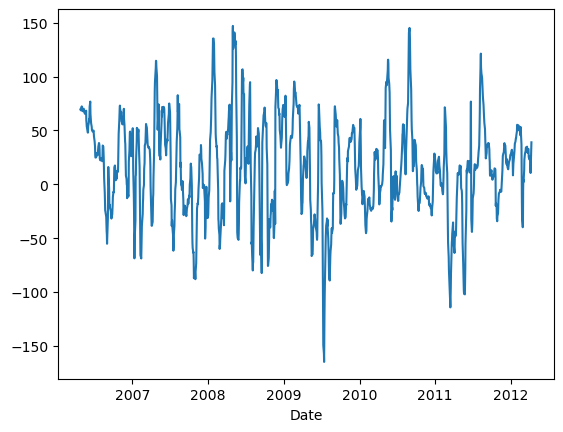

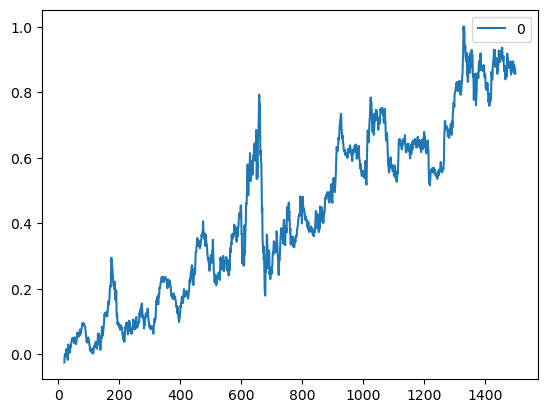

In [8]:
# Trading Price Spread

import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts
#import statsmodels.tsa.vector_ar.vecm as vm

df=pd.read_csv('datas/inputData_GLD_USO.csv')
df['Date']=pd.to_datetime(df['Date'],  format='%Y%m%d').dt.date # remove HH:MM:SS
df.set_index('Date', inplace=True)

lookback=20
hedgeRatio=np.full(df.shape[0], np.nan)
# 计算对冲比率
for t in np.arange(lookback, len(hedgeRatio)):
    regress_results=sm.ols(formula="USO ~ GLD", data=df[(t-lookback):t]).fit() # Note this can deal with NaN in top row
    hedgeRatio[t-1]=regress_results.params.iloc[1]
print('hedgeRatio:',hedgeRatio)
print('ts.add_constant(-hedgeRatio):',ts.add_constant(-hedgeRatio))
# 计算投资组合净值
yport=np.sum(ts.add_constant(-hedgeRatio)[:, [1,0]]*df, axis=1)
yport.plot()

# Apply a simple linear mean reversion strategy to GLD-USO
# 实现简单的线性均值回归策略

# 计算投资单位数。这个公式实际上是计算yport与其移动平均值的偏差，然后除以其标准差。
# 这个值表示相对于其历史平均表现，今天的投资组合表现有多好（或有多差）。正值表示今天的表现优于平均水平，负值表示今天的表现低于平均水平。
# 乘以-1是为了反转符号，使得正值表示买入，负值表示卖出。
numUnits =-(yport-yport.rolling(lookback).mean())/yport.rolling(lookback).std() # capital invested in portfolio in dollars.  movingAvg and movingStd are functions from epchan.com/book2
print('numUnits:',numUnits)
# np.tile(numUnits.values, [2, 1]):
# np.tile函数用于重复数组的元素以创建新的数组。
# numUnits.values是一个一维数组（假设numUnits只有一列），[2, 1]表示在行方向上重复两次，在列方向上重复一次。
# 结果是一个二维数组，其中第一行是numUnits.values的复制，第二行也是numUnit.values的复制。
positions=pd.DataFrame(np.tile(numUnits.values, [2, 1]).T * ts.add_constant(-hedgeRatio)[:, [1,0]] *df.values) # results.evec(:, 1)' can be viewed as the capital allocation, while positions is the dollar capital in each ETF.
pnl=np.sum((positions.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
ret=pnl/np.sum(np.abs(positions.shift()), axis=1)
# np.cumprod 是 NumPy 库中的一个函数，用于计算数组的累积积（cumulative product）。
# 累积积是指从数组的第一个元素开始，逐个元素相乘，直到当前元素为止的所有元素的乘积
pd.DataFrame((np.cumprod(1+ret)-1)).plot()
print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))


APR=0.099520 Sharpe=0.553442


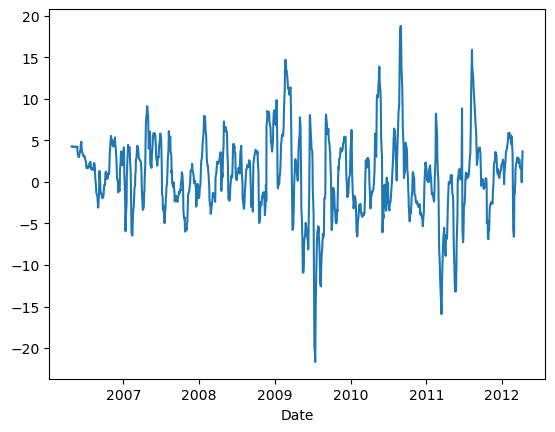

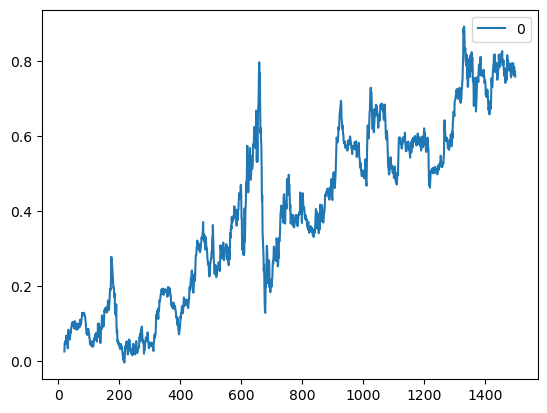

In [12]:
# Trading Log Price Spread
# 使用价格对数值的差分模式所产生的效应
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts

df=pd.read_csv('datas/inputData_GLD_USO.csv')
df['Date']=pd.to_datetime(df['Date'],  format='%Y%m%d').dt.date # remove HH:MM:SS
df.set_index('Date', inplace=True)

lookback=20
hedgeRatio=np.full(df.shape[0], np.nan)
for t in np.arange(lookback, len(hedgeRatio)):
    # regress_results=sm.ols(formula="USO ~ GLD", data=df[(t-lookback):t]).fit()
    regress_results=sm.ols(formula="USO ~ GLD", data=np.log(df[(t-lookback):t])).fit() # Note this can deal with NaN in top row
    hedgeRatio[t-1]=regress_results.params.iloc[1]
# yport=np.sum(ts.add_constant(-hedgeRatio)[:, [1,0]]*df, axis=1)
yport=np.sum(ts.add_constant(-hedgeRatio)[:, [1,0]]*np.log(df), axis=1)
yport.plot()

# Apply a simple linear mean reversion strategy to GLD-USO
numUnits =-(yport-yport.rolling(lookback).mean())/yport.rolling(lookback).std() # capital invested in portfolio in dollars.  movingAvg and movingStd are functions from epchan.com/book2
positions=pd.DataFrame(np.tile(numUnits.values, [2, 1]).T * ts.add_constant(-hedgeRatio)[:, [1,0]] ) #  positions is the dollar capital in each ETF.
pnl=np.sum((positions.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
ret=pnl/np.sum(np.abs(positions.shift()), axis=1)
pd.DataFrame(np.cumprod(1+ret)-1).plot()
print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))


APR=-0.140674 Sharpe=-0.749583


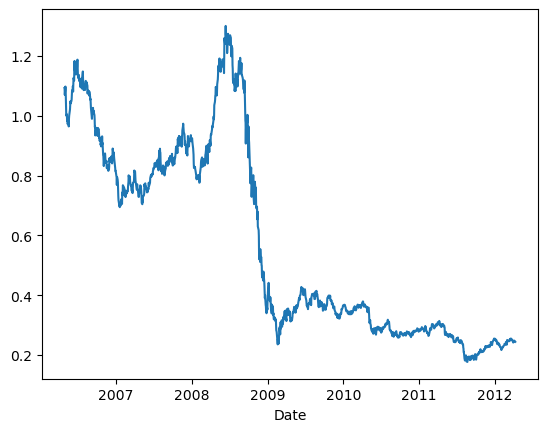

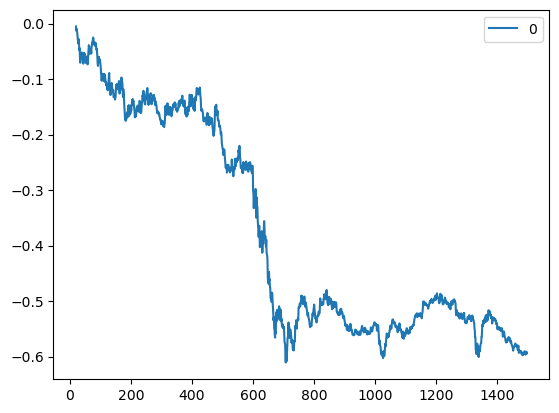

In [13]:
# Trading Ratio
# 相应的价格比率模式所生成的效应与价差模式和自适应对冲比率模式相比较而言，其看起来根本就不是不平稳的。所以，如果我们发现相关的均值回归模式的表现不佳，且生成负的年化收益率时，我们都不应该感到惊讶，

import numpy as np
import pandas as pd

df=pd.read_csv('datas/inputData_GLD_USO.csv')
df['Date']=pd.to_datetime(df['Date'],  format='%Y%m%d').dt.date # remove HH:MM:SS
df.set_index('Date', inplace=True)

lookback=20
ratio=df['USO']/df['GLD']
ratio.plot()

#yport=np.sum(ts.add_constant(-hedgeRatio)[:, [1,0]]*np.log(df), axis=1)
#yport.plot()

# Apply a simple linear mean reversion strategy to GLD-USO
numUnits =-(ratio-ratio.rolling(lookback).mean())/ratio.rolling(lookback).std() # capital invested in portfolio in dollars.  movingAvg and movingStd are functions from epchan.com/book2
positions=pd.DataFrame(np.tile(numUnits.values, [2, 1]).T * np.ones((numUnits.shape[0], 2)) * np.array([-1, 1]) ) # positions in dollar invested
pnl=np.sum((positions.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
ret=pnl/np.sum(np.abs(positions.shift()), axis=1)
# (np.cumprod(1+ret)-1).plot()
pd.DataFrame((np.cumprod(1+ret)-1)).plot()
print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))


APR=0.149725 Sharpe=1.110355


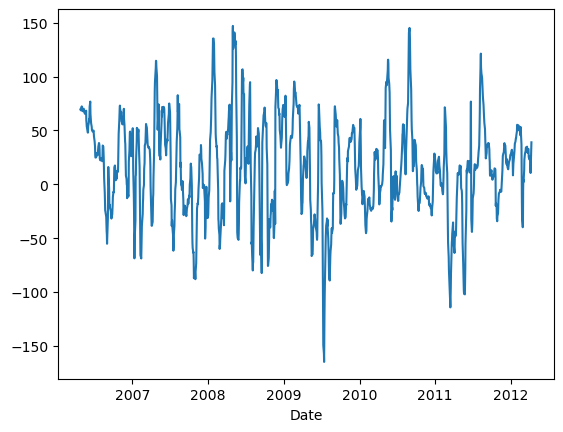

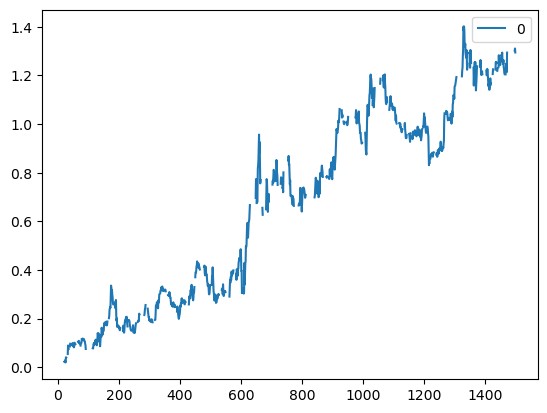

In [14]:
# Bollinger Band Mean Reversion Strategy
# 布林线带均值回归策略
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts
#import statsmodels.tsa.vector_ar.vecm as vm

df=pd.read_csv('datas/inputData_GLD_USO.csv')
df['Date']=pd.to_datetime(df['Date'],  format='%Y%m%d').dt.date # remove HH:MM:SS
df.set_index('Date', inplace=True)

lookback=20
hedgeRatio=np.full(df.shape[0], np.nan)
for t in np.arange(lookback, len(hedgeRatio)):
    regress_results=sm.ols(formula="USO ~ GLD", data=df[(t-lookback):t]).fit() # Note this can deal with NaN in top row
    hedgeRatio[t-1]=regress_results.params.iloc[1]

yport=np.sum(ts.add_constant(-hedgeRatio)[:, [1,0]]*df, axis=1)
yport.plot()
# 这里我们需要注意的是：多单入场信号longsEntry与空单入场信号shortsEntry是T×1型的逻辑数组，多单离场信号longsExit和空单离场信号shortsExit也是如此。
# 我们以numUnitsLong函数将与多单相关的单位投资组合的数量单位进行初始化的处理，这是一个T×1型的数组，然后，在出现多单入场信号之时，设置其值为1，而在多单离场信号出现之时，则设置其值为0；
# 而对于空单的数量单位，我们则进行反向设置即可；在没有入场、离场信号的时间序列之内，我们使用失踪数据填充函数fillMissingData来提取前一天的数量单位（fillMissingData函数从数组的第二行开始，
# 并以前一行各单元格的价值覆盖本期单元格的非数变量（NaN值），相应程序可以从我的网站下载）。一旦我们计算出代表多单数量单位的numUnitsLong函数和代表空单单位数量的numUnitsShort函数的数值，
# 我们就可以计算相关数量单位的净值。
# Bollinger band strategy
entryZscore=1
exitZscore=0

MA=yport.rolling(lookback).mean()
MSTD=yport.rolling(lookback).std()
zScore=(yport-MA)/MSTD

longsEntry=zScore < -entryZscore
longsExit =zScore > -entryZscore

shortsEntry=zScore > entryZscore
shortsExit =zScore < exitZscore

numUnitsLong=np.zeros(longsEntry.shape)
numUnitsLong[:]=np.nan

numUnitsShort=np.zeros(shortsEntry.shape)
numUnitsShort[:]=np.nan

numUnitsLong[0]=0
numUnitsLong[longsEntry]=1
numUnitsLong[longsExit]=0
numUnitsLong=pd.DataFrame(numUnitsLong)
# numUnitsLong.fillna(method='ffill', inplace=True)
numUnitsLong.ffill(inplace=True)

numUnitsShort[0]=0
numUnitsShort[shortsEntry]=-1
numUnitsShort[shortsExit]=0
numUnitsShort=pd.DataFrame(numUnitsShort)
# numUnitsShort.fillna(method='ffill', inplace=True)
numUnitsShort.ffill(inplace=True)

numUnits=numUnitsLong+numUnitsShort
positions=pd.DataFrame(np.tile(numUnits.values, [1, 2]) * ts.add_constant(-hedgeRatio)[:, [1,0]] *df.values) #  [hedgeRatio -ones(size(hedgeRatio))] is the shares allocation, [hedgeRatio -ones(size(hedgeRatio))].*y2 is the dollar capital allocation, while positions is the dollar capital in each ETF.
pnl=np.sum((positions.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
ret=pnl/np.sum(np.abs(positions.shift()), axis=1)
pd.DataFrame((np.cumprod(1+ret)-1)).plot()

print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))


对于一对真正的、具有协整性质的价格系列来说，确定对冲比率的方法非常简单：只要我们能够找到尽可能多的历史数据，然后，使用回归拟合相关的普通最小二乘法（OLS），或使用约翰森检验法则找到特征向量就可以了。

对于到目前为止我们所讨论过的所有均值回归之交易策略而言，我们只是提取一个移动的回溯期，然后在此期限内计算回归系数，或特定的约翰森检验相关的特征向量，不过，此种方法有一个缺陷，即如果回溯周期过短，那么，随着时间的推进，我们需要删除初始的价格以及最新的价格，如此则会对相关比率产生一个突然的、人为的冲击；如果我们使用移动平均线，或者移动标准差来计算当前价格系列的平均值和标准差，我们也会面临相同的问题。
其实，指数加权移动平均线（EMA）就相当于前述的这种加权方式，但是，目前关于“为什么指数权重下降就是一个最优化的指标”这个问题，尚无比较清晰的答案。这里，我们将描述一个使用卡尔曼过滤法则更新对冲比率的模式，此模式可以避免因随意挑选一个加权方案而产生误差的问题（Montana、Triantafyllopoulos和Tsagaris，2009）。

卡尔曼过滤法是最优化的线性算法，它能够基于一个可观测变量的最新值更新一个隐变量的期望值（关于这个话题，我们可以参看“卡尔曼，2007”）。此法则是线性的，因为它假定可观测变量是与噪声相关之隐变量的函数，同时，此法则还假设t时刻所对应的隐变量是其本身于t-1时刻（与噪声变量相关）的线性函数，而出现在这些函数中的噪声变量具有高斯分布的性质（因此，我们可以指定一个渐变式的协方差矩阵，这里我们假设相应的均值都是零）。因为所有的这些线性关系，t时刻相对应的隐变量的期望值也是其自身于观测期t时刻之前的期望值的一个线性函数，同时，它也是于t时刻所能观测到的变量的数值的线性函数。如果我们把噪声的分布假定为高斯分布，则卡尔曼过滤法就是一种最优化的方法，并且可以将相应的预期变量的均方误差最小化。

对于卡尔曼过滤法则的每一次应用而言，我们需要先弄清楚相关的变量和矩阵：
* （1）可观测变量（向量）
* （2）隐变量（向量）
* （3）状态转换模型（矩阵）
* （4）观测模型（矩阵）

上述模式是相关应用程序当中唯一具有创造性的部分，因为一旦相关数值被指定之后，那剩下的就是一个机械的应用算法了。作为交易者，我们不需要知道如何推导这些物理变量之间的关系，我们只需要知道在哪里能够找到好的软件包，进而为我们提供正确的答案。


APR=0.305703 Sharpe=3.314831


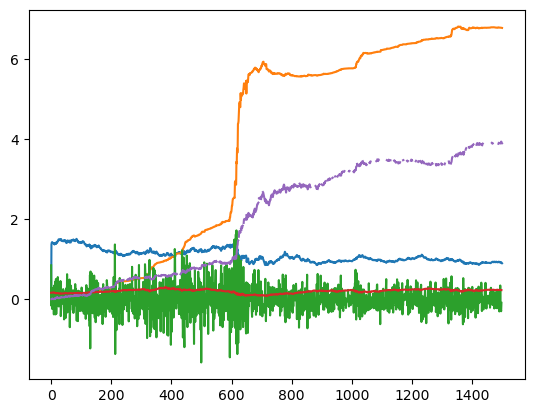

In [15]:
# Kalman Filter Mean Reversion Strategy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts
#import statsmodels.tsa.vector_ar.vecm as vm

df=pd.read_csv('datas/inputData_EWA_EWC_IGE.csv')
# 删除列'IGE'
df = df.drop('IGE', axis=1)

df['Date']=pd.to_datetime(df['Date'],  format='%Y%m%d').dt.date # remove HH:MM:SS
df.set_index('Date', inplace=True)

x=df['EWA']
y=df['EWC']
# 对x进行预处理，添加一列常数项以适应可能的截距偏移
x=np.array(ts.add_constant(x))[:, [1,0]] # Augment x with ones to  accomodate possible offset in the regression between y vs x.

# 初始化一些变量，如卡尔曼滤波器的状态协方差矩阵R、预测误差协方差矩阵P、回归系数beta、过程噪声协方差矩阵Vw和观测噪声协方差矩阵Ve。
delta=0.0001 # delta=1 gives fastest change in beta, delta=0.000....1 allows no change (like traditional linear regression).

yhat=np.full(y.shape[0], np.nan) # measurement prediction
e=yhat.copy()
Q=yhat.copy()

# For clarity, we denote R(t|t) by P(t). Initialize R, P and beta.
R=np.zeros((2,2))
P=R.copy()
beta=np.full((2, x.shape[0]), np.nan)
Vw=delta/(1-delta)*np.eye(2)
Ve=0.001

# Initialize beta(:, 1) to zero
beta[:, 0]=0
# 使用卡尔曼滤波器迭代更新回归系数beta。在每个时间步长t，首先根据上一时刻的beta值更新R，然后计算预测值yhat、预测误差e和观测噪声协方差Q。接着计算卡尔曼增益K，并使用它来更新beta和P
# Given initial beta and R (and P)
for t in range(len(y)):
    if t > 0:
        beta[:, t]=beta[:, t-1]
        R=P+Vw
            
    yhat[t]=np.dot(x[t, :], beta[:, t])
#    print('FIRST: yhat[t]=', yhat[t])
    
    Q[t]=np.dot(np.dot(x[t, :], R), x[t, :].T)+Ve
#    print('Q[t]=', Q[t])

    # Observe y(t)
    e[t]=y.iloc[t]-yhat[t] # measurement prediction error
#    print('e[t]=', e[t])
#    print('SECOND: yhat[t]=', yhat[t])

    
    K=np.dot(R, x[t, :].T)/Q[t] #  Kalman gain
#    print(K)
    
    beta[:, t]=beta[:, t]+np.dot(K, e[t]) #  State update. Equation 3.11
#    print(beta[:, t])
    
    # P=R-np.dot(np.dot(K, x[t, :]), R) # State covariance update. Euqation 3.12
    P=R-np.dot(np.outer(K, x[t, :]), R) # Thanks to Matthias for chaning np.dot -> np.outer!

#    print(R)

plt.plot(beta[0, :])
plt.plot(beta[1, :])
plt.plot(e[2:])
plt.plot(np.sqrt(Q[2:]))

# 根据预测误差e和观测噪声协方差Q来确定买入和卖出的信号（longsEntry、longsExit、shortsEntry和shortsExit）。
longsEntry=e < -np.sqrt(Q)
longsExit =e > 0

shortsEntry=e > np.sqrt(Q)
shortsExit =e < 0

# 计算每个时间步长的持仓数量（numUnitsLong和numUnitsShort），并将它们合并为一个总持仓数量numUnits。
numUnitsLong=np.zeros(longsEntry.shape)
numUnitsLong[:]=np.nan

numUnitsShort=np.zeros(shortsEntry.shape)
numUnitsShort[:]=np.nan

numUnitsLong[0]=0
numUnitsLong[longsEntry]=1
numUnitsLong[longsExit]=0
numUnitsLong=pd.DataFrame(numUnitsLong)
# numUnitsLong.fillna(method='ffill', inplace=True)
numUnitsLong.ffill(inplace=True)

numUnitsShort[0]=0
numUnitsShort[shortsEntry]=-1
numUnitsShort[shortsExit]=0
numUnitsShort=pd.DataFrame(numUnitsShort)
# numUnitsShort.fillna(method='ffill', inplace=True)
numUnitsShort.ffill(inplace=True)

numUnits=numUnitsLong+numUnitsShort
# 根据持仓数量和回归系数beta构建投资组合，并计算每日盈亏pnl和投资组合的累计收益率。
positions=pd.DataFrame(np.tile(numUnits.values, [1, 2]) * ts.add_constant(-beta[0,:].T)[:, [1,0]] *df.values) #  [hedgeRatio -ones(size(hedgeRatio))] is the shares allocation, [hedgeRatio -ones(size(hedgeRatio))].*y2 is the dollar capital allocation, while positions is the dollar capital in each ETF.
pnl=np.sum((positions.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
ret=pnl/np.sum(np.abs(positions.shift()), axis=1)
(np.cumprod(1+ret)-1).plot()
print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))
#APR=0.313225 Sharpe=3.464060